In [106]:
import igraph as ig
import pandas as pd
import numpy as np
from operator import attrgetter
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.stats import rankdata

In [107]:
def lmap(*args, **kwargs):
    return list(map(*args, **kwargs))

# Home assignment 3.

## Part 1.

The goal of this assignment is to analyse the joint network (agreggated from your VK egocentric) https://github.com/kurmukovai/iitp_networks1/tree/master/2022/data/vk_students .

1. Compute centrality measures for the joint network: degree, closeness, betweenness, eigenvector; interpret the ranking results (does ranking make sense?).
2. Using different layouts plot you network (you can use different node characteristics as node size/color). 
3. Find network communities using either `igraph` or `community-louvain` package, analyse the results, can you identify clusters related to your egocentric network?

https://python-louvain.readthedocs.io/en/latest/api.html

In [108]:
edges = pd.read_csv('../data/vk_students/edges.csv', usecols=[1, 2])
users = pd.read_csv('../data/vk_students/users.csv', usecols=[1,2,3,4,5,6])

In [109]:
users

,Birthday,City,Name,Sex,University,User id
0,12.3,Saint Petersburg,Ekaterina,1,No,37281
1,12.6.1985,Saint Petersburg,Kirill,2,No,393551
2,17.6,Saint Petersburg,Elena,1,"БГУ (бывш. БГПИ, БФ НГУ)",727643
3,1.12.1989,Saint Petersburg,Tatyana,1,No,2332795
4,27.11.1980,Saint Petersburg,Andrey,2,СПбГУ,2340546
...,...,...,...,...,...,...
1623,NaN,NaN,DELETED,1,NaN,353564861
1624,NaN,NaN,Maria,1,NaN,137235024
1625,NaN,NaN,Mikhail,2,Филиал ДИНО государственного университета «Дуб...,10772558
1626,3.5,NaN,Vanya,2,НИУ ВШЭ (ГУ-ВШЭ),165391357


In [110]:
def vertex_id_edges():
    for uid1, uid2 in edges.itertuples(index=False):
        vid1 = users.index[users['User id'] == uid1]
        vid2 = users.index[users['User id'] == uid2]
        
        if vid1.empty or vid2.empty:
            continue
        
        yield vid1.item(), vid2.item()

In [111]:
G = ig.Graph(n=len(users))
G.add_edges(vertex_id_edges())

In [112]:
G.is_connected()

False

In [113]:
gcc = G.connected_components('weak')[0]
G_gcc = G.subgraph(gcc)
users_gcc = users.iloc[gcc].reset_index()

In [114]:
all_rankings = {}
all_centralities = {}
centrality_types = [
    'degree',
    'closeness',
    'betweenness',
    'eigenvector_centrality'
]

for centrality in centrality_types:
    all_centralities[centrality] = np.array(attrgetter(centrality)(G_gcc)())
    all_rankings[centrality] = rankdata(-all_centralities[centrality], method='ordinal')

In [115]:
for centrality, ranking in all_rankings.items():
    users_gcc[centrality] = all_centralities[centrality]
    print(f'Top {centrality}: \n{users_gcc.iloc[ranking.argmin()]}\n')

Top degree: 
index                72
Birthday      12.9.1999
City                 No
Name            Grigory
Sex                   2
University           No
User id        82561236
degree              273
Name: 72, dtype: object

Top closeness: 
index                   282
Birthday           3.8.1959
City                 Moscow
Name                Nikolay
Sex                       2
University    МФТИ (Физтех)
User id           575974633
degree                  243
closeness          0.425703
Name: 282, dtype: object

Top betweenness: 
index                    282
Birthday            3.8.1959
City                  Moscow
Name                 Nikolay
Sex                        2
University     МФТИ (Физтех)
User id            575974633
degree                   243
closeness           0.425703
betweenness    169656.836545
Name: 282, dtype: object

Top eigenvector_centrality: 
index                               72
Birthday                     12.9.1999
City                               

### Анализ ранжирования:
- Видно, что ранжирование по степени и по eigenvector centrality поставило в топ одного и того же человека - Гришу Цвик, это студент который решает много организационных вопросов, почти единолично распространяет учебные материалы на всех курсах ФПМИ. Логично, что среди нас и наших друзей он просто знаком с наибольшим количеством людей, было ожидаемо увидеть его первым в этом ранжировании, первый и четвёртый методы отработали логично
- Ранжирование по betweenness и closeness поставило в топ Николая Науменко, заведующего редакцией издательства АСТ. Он набрал большую аудиторию из МФТИ и не только, судя по всему разослав всем подписчикам физтешных пабликов приглашения в друзья, так что очень много людей из списка его друзей с ним не знакомы, и тем более не знакомы с другими его "друзьями". Логично, что он таким образом соединяет разрозненные сообщества, которые иначе никак не пересекаются.

In [126]:
def draw_graph(layout, vsize=1.):
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))

    for i, centrality in enumerate(centrality_types):
        ax = axs[i % 2, i // 2]

        top_nodes = all_rankings[centrality] <= 3
        def select_top(top, other):
            return np.where(top_nodes, top, other).tolist()

        vertex_size = np.copy(all_centralities[centrality]).astype(float)

        vertex_size -= vertex_size.min()
        vertex_size /= vertex_size.max()
        vertex_size = np.clip(vertex_size, 5e-2, 0.3) * vsize

        ig.plot(
            G_gcc,
            layout=layout,
            target=ax,
            vertex_size=vertex_size,
            vertex_color=select_top('red', 'gray'),
            vertex_frame_color='white',
            vertex_frame_width=0.1,
            edge_color='light gray',
            edge_width=0.1,
            vertex_label_size=8,
            vertex_order=np.argsort(all_centralities[centrality]),
            vertex_label=select_top(users_gcc['Name'], None),
        )

        ax.set_title(centrality)

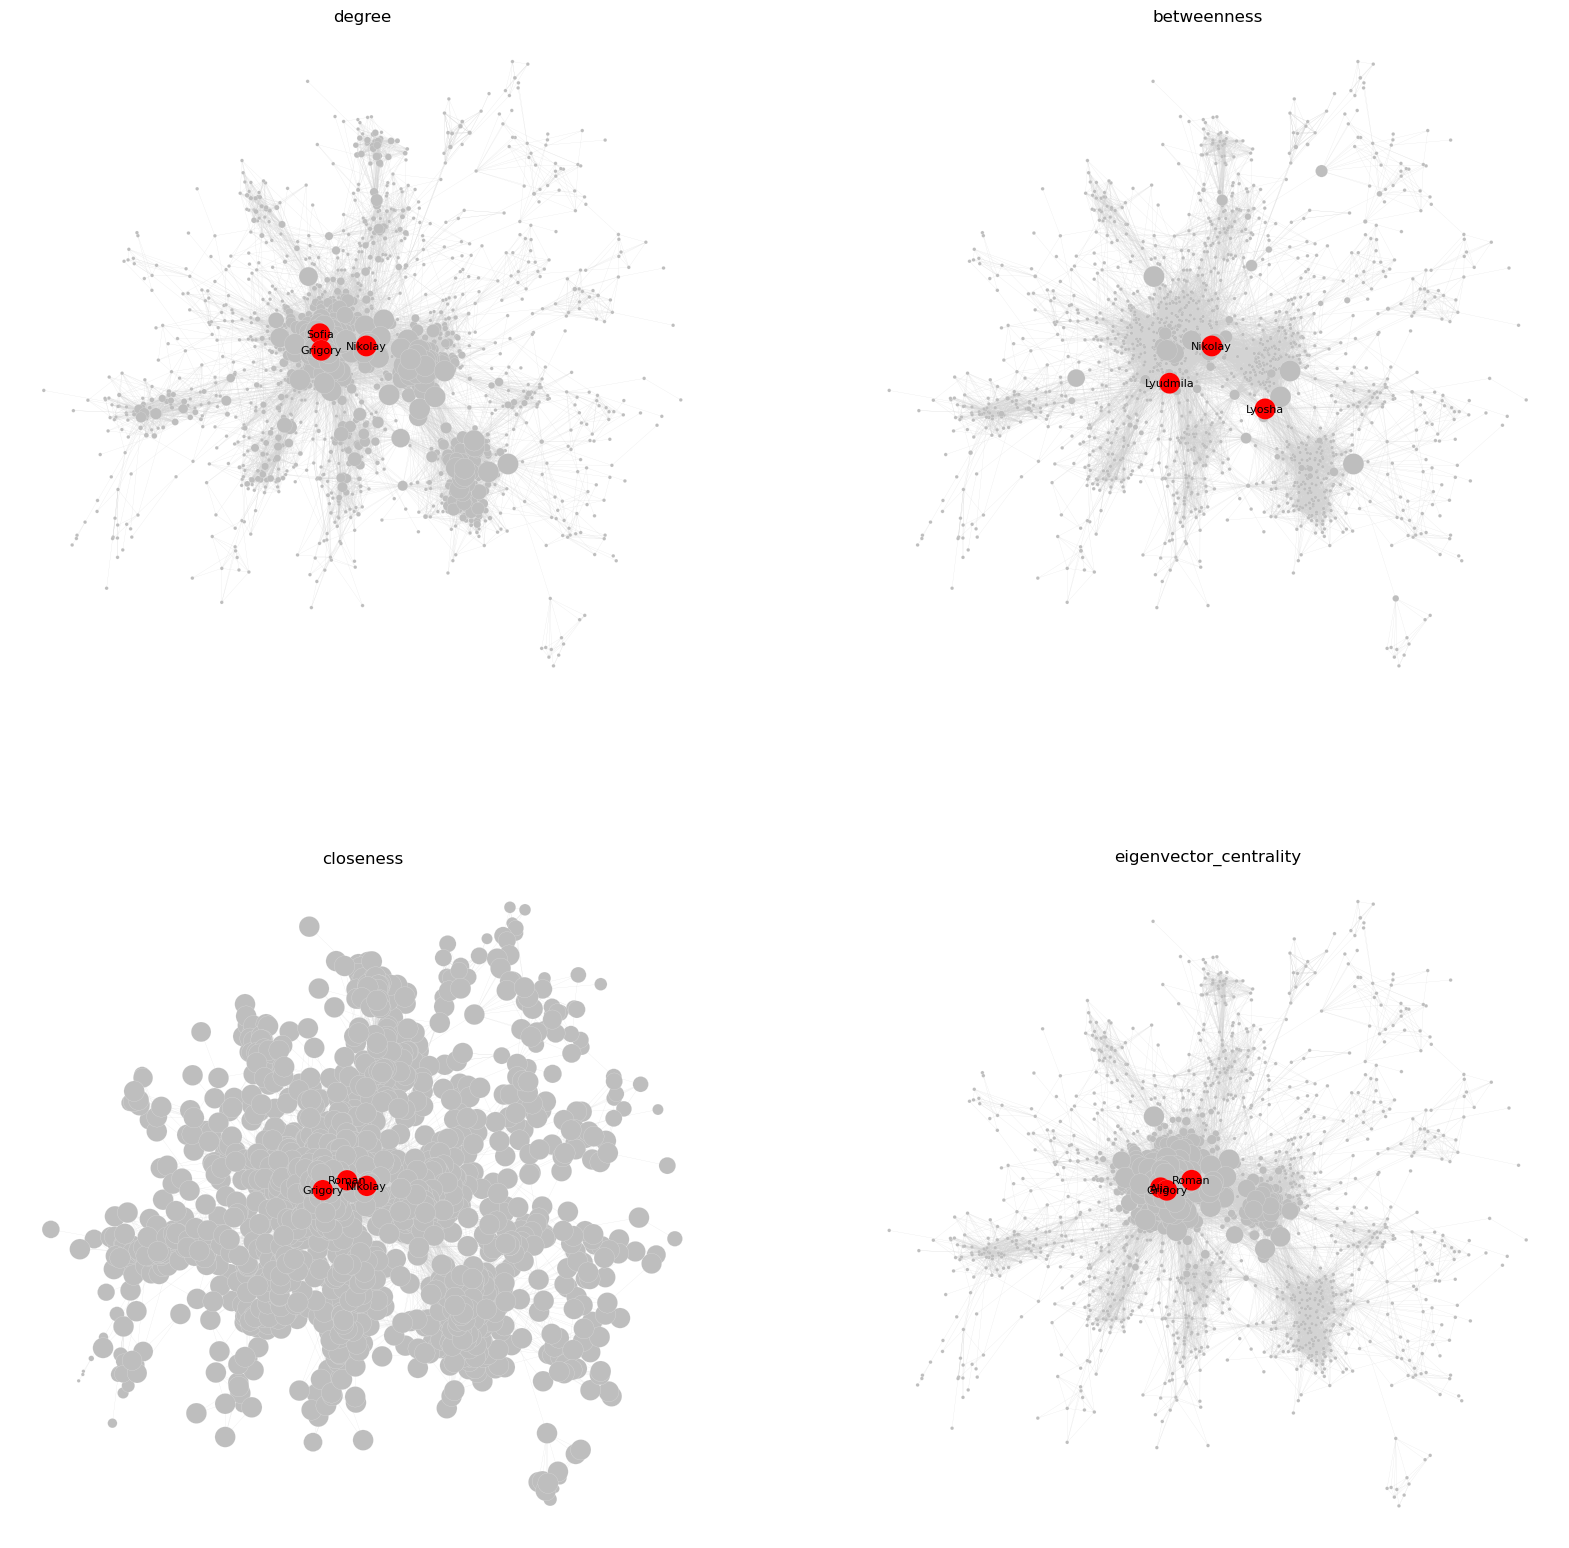

In [124]:
draw_graph(G_gcc.layout_fruchterman_reingold())

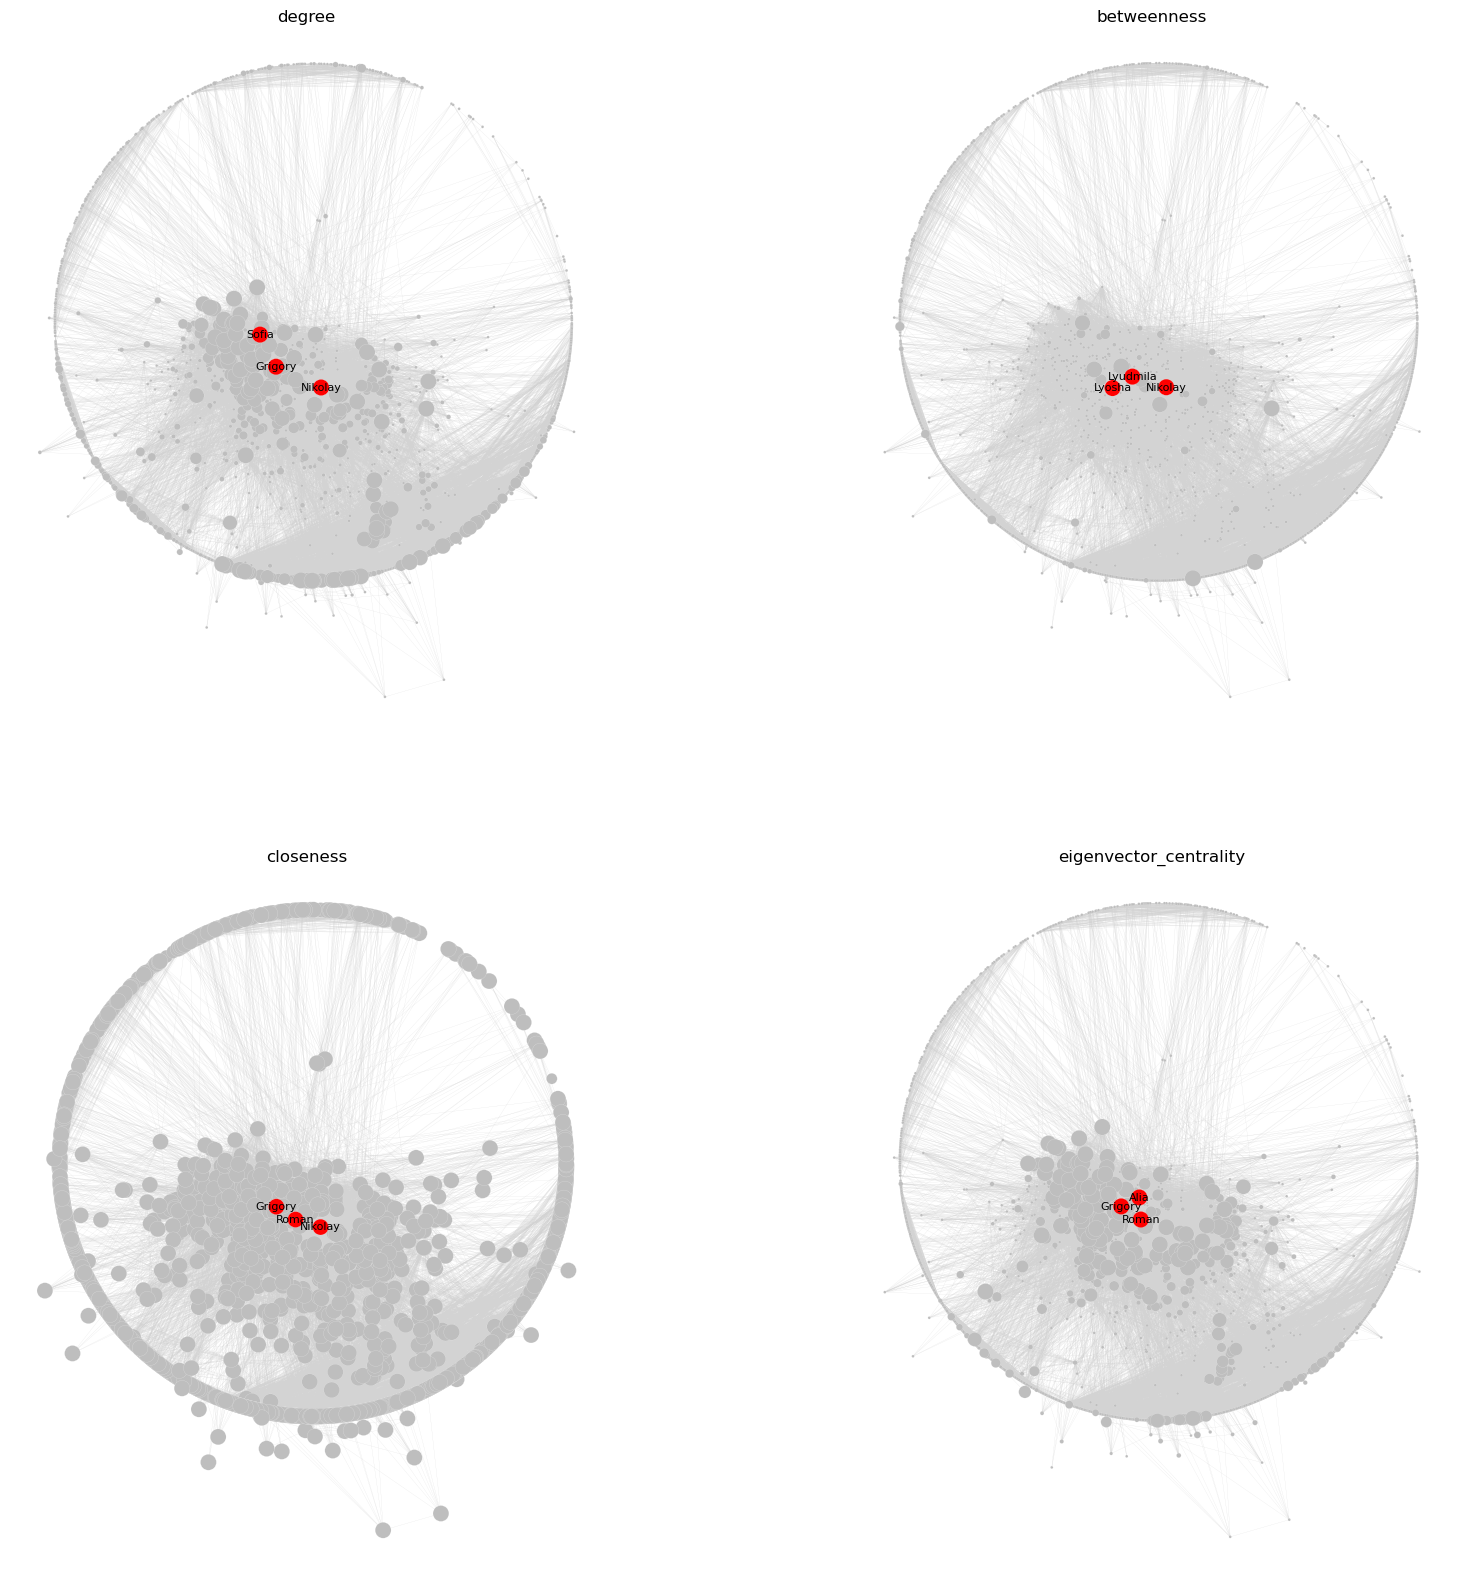

In [127]:
draw_graph(G_gcc.layout('kk'), 3)

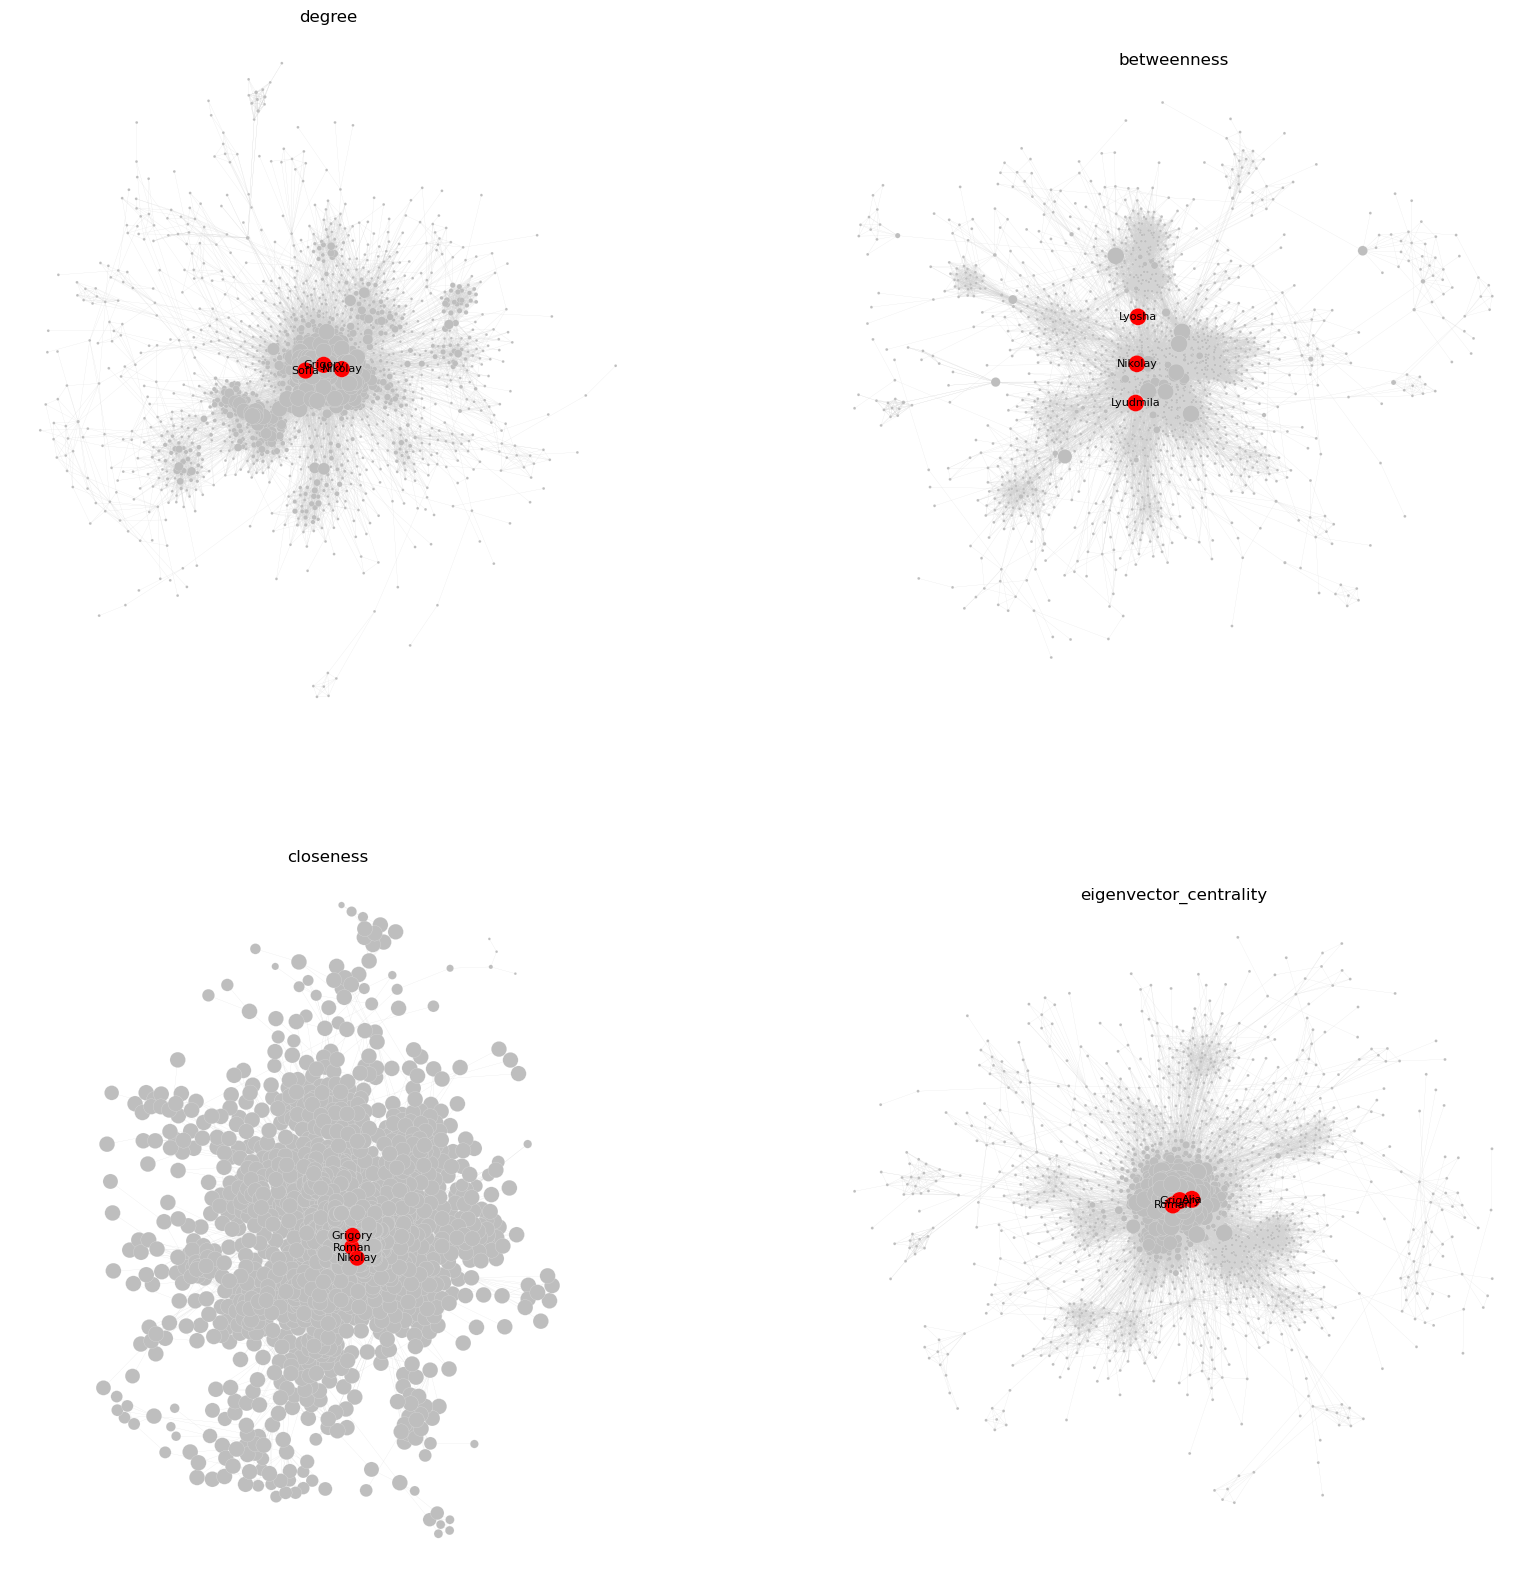

In [129]:
draw_graph('graphopt', 100)

## Part 2. 

### Community detection using Spectral Clustering

Given graph $G$ with $n$ nodes, find non-overlapping node "communities": $k$ groups of nodes that are densely intra connected and have low number of inter connections.

- Compute square diagonal matrix of node degrees $D$. 
    $$D_{ii} = \sum_i A_{ij}, D_{ij} = 0, i \neq j$$
- Construct graph Laplacian 
    $$L_{unnormed} = D - A$$
Find $0 = \lambda_0 \leq \lambda_1 \leq \lambda_2 \leq \ldots \leq \lambda_m$ smallest eigenvalues of $L$ and construct matrix $X$ by stacking $m$ corresponding eigenvectors ($v_1, \ldots v_m$) as columns of $X$. Matrix $X$ has size $n \times m$, its rows are "spectral representaion" of graph nodes.
   
- Run k-means algorithm on matrix X and assign nodes with labels obtained by k-means.

---

Implement 3 algorithms described in https://arxiv.org/abs/0711.0189 :
1. Unnormalized spectral clustering 
2. Normalized spectral clustering according to Shi and Malik (2000)
3. Normalized spectral clustering according to Ng, Jordan, and Weiss (2002)

## Compare 3 versions of Spectral clustering on `Karate Club dataset`
    
using `Adjusted Rand Index` (3 pairwise comparisons), `Modularity` (3 numbers) and visually, plotting points in a corresponding 2 dimensional spaces (spanned by eigenvectors).

Theoretical questions:

1. Why does the smallest eigenvalue of unnormalized Laplacian is always equal to 0? 
2. From network point of view, what does Symmetric normalization do? 
3. Under what conditions Symmetric and Random walk normalizations yield the same result? 
  
    
Sources:
1. Andrew Ng paper on spectral clustering https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf
2. Tutorial on spectral clustering with multiple theoretical views on the problem https://arxiv.org/abs/0711.0189
3. Amazing explanation from James R. Lee https://www.youtube.com/watch?v=8XJes6XFjxM